In [320]:
import numpy as np
from numpy.linalg import norm 
import matplotlib.pyplot as plt


# For the data structure, we need the following objects: 
# 1) The ring which is made up of cells and should also contain all other data structures
# 2) A cell which is made up of edges 
### (or half-edges, which is only the "half" of the edge that faces the cell, 
### the one on the opposite side might have different properties)
# 3) A half-edge, which consists of two vertices
# 4) A vertex, which is a simple 2D vector

### To make it easier to loop through the objects, we include links:
# - A cell has a reference to both a base vertex and half-edge
# - Half-edges are defined in closed loops in counter-clockwise order, such that they have a link to the previous and  
#   next half edge in the current cell. Also, they have a reference to the cell that they are a part of, as 
#   well as a reference to the half-edge in the neighboring cell or region

# Physical parameters are to be defined on the corresponding object, such as Cell() for anything area-related 
# and Half_Edge() for anything related to the side lengths or surface tensions


# a basic 2D vector will be taken from numpy, np.array and used for vertices
        

# node class for a double-linked list of half-edges of cells, with a link to the half-edge loop on the other side of the edge
class Half_Edge():
    def __init__(self, v1, v2, ke):
        self.next = None
        self.prev = None
        self.opposite = None
        self.v1 = v1
        self.v2 = v2
        self.refcell = None
        self.ke = ke
        
    # return the length of the edge vector
    def length(self):
        return norm(self.v2-self.v1)
    
    # return the edge vector
    def vec(self):
        return(self.v2-self.v1)
    
    # return the midpoint between the two edge vertices
    def midpoint(self):
        return ((self.v1+self.v2)/2)
        
        
# cell node class. Has a link to the vertex on its lower right side with respect to the center and the next half edge in counter-clockwise direction.
class Cell():
    def __init__(self, v1, halfedge1, target_area = 1):
        self.v1 = v1
        self.halfedge1 = halfedge1
        self.target_area = target_area
        
    # calculate the area from the edge vertices
    def area(self):
        vec1 = self.v1
        vec2 = self.halfedge1.v2
        vec3 = self.halfedge1.next.v2
        vec4 = self.halfedge1.prev.v1
        
        return 0.5 * ( (vec1[0]*vec2[1] + vec2[0]*vec3[1] + vec3[0]*vec4[1] + vec4[0]*vec1[1]) - (vec2[0]*vec1[1] + vec3[0]*vec2[1] + vec4[0]*vec3[1] + vec1[0]*vec4[1]) )
        
    # calculate the normal on the cell defined as the normalized vector from the center of mass to the center of the outer edge
    def normal(self):
        vec1 = self.v1
        vec2 = self.halfedge1.v2
        vec3 = self.halfedge1.next.v2
        vec4 = self.halfedge1.prev.v1
        # some geometric normal definition. Outer vertices minus inner vertices divided by four
        normal_vec = (vec2 + vec3 - vec1 - vec4)/4.0
        
        return (normal_vec/norm(normal_vec))
    
    def midpoint(self):
        vec1 = self.v1
        vec2 = self.halfedge1.v2
        vec3 = self.halfedge1.next.v2
        vec4 = self.halfedge1.prev.v1
        return ((vec1 + vec2 + vec3 + vec4) / 4.0)
        

# ring class, has functions for maintenance of the data structures
# includes a list for cell, edge and vertex node objects
class Ring():
    def __init__(self):
        self.cells = np.array([])
        self.halfedges = np.array([])
        self.vertices = np.array([[]])
        self.num_vertices = 0
        self.num_edges = 0
        self.num_cells = 0
        self.debug = 0
      
    # string representation of Ring objects for the print() function
    def __str__(self):
        return 'Ring object with ' + str(self.num_cells) + ' cells, ' + str(self.num_edges) + ' half-edges and ' + str(self.num_vertices) + ' vertices.' 
        
    # create an initial ring around the origin with a specified radius and cell count
    def initialize(self, cellcount, radius = 1.0):
        # make sure that a minimal number of cells is used
        if(cellcount < 5) : 
            print("Cell count specified is too small. Setting N=5.")
            cellcount = 5
            
        # use a default value of ke for now
        ke = 1
        
        # use a value of +- 15% of the given radius as the respective radii for inner and outer vertices
        rad_inner = 0.85 * radius
        rad_outer = 1.15 * radius
        
        
        # divide a full circle into cellcount segments 
        segment_angle = 2 * np.pi / cellcount
        
        # create vertices; First vertex is on the inside, then outside, then continue in counter-clockise direction
        for i in range(cellcount+1) :
            # get vertex x and y from polar coordinates
            if(i < cellcount) :
                vert_x = rad_inner * np.cos(i*segment_angle)
                vert_y = rad_inner * np.sin(i*segment_angle)
                if(i == 0) :
                    self.vertices = np.array([[vert_x, vert_y]])
                else :
                    self.vertices = np.append(self.vertices, np.array([[vert_x, vert_y]]), axis=0)

                vert_x = rad_outer * np.cos(i*segment_angle)
                vert_y = rad_outer * np.sin(i*segment_angle)
                self.vertices = np.append(self.vertices, np.array([[vert_x, vert_y]]), axis=0)

                self.num_vertices += 2
        for i in range(cellcount+1) :    
            # create the half-edge loops for the cells, start once 4 vertices have been created
            # create the cell from the 4 half edges
            if(i > 0) :
                # create edges
                self.halfedges = np.append(self.halfedges, Half_Edge(self.vertices[(i-1)*2],   self.vertices[(i-1)*2+1], ke))
                self.halfedges = np.append(self.halfedges, Half_Edge(self.vertices[(i-1)*2+1], self.vertices[ np.mod(i,cellcount)   *2+1], ke))
                self.halfedges = np.append(self.halfedges, Half_Edge(self.vertices[ np.mod(i,cellcount)   *2+1], self.vertices[ np.mod(i,cellcount)   *2],   ke))
                self.halfedges = np.append(self.halfedges, Half_Edge(self.vertices[ np.mod(i,cellcount)   *2],   self.vertices[(i-1)*2],   ke))
                
                # create cell
                self.cells = np.append(self.cells, Cell(self.vertices[(i-1)*2], self.halfedges[(i-1)*4]))
                self.cells[i-1].target_area = self.cells[i-1].area
                for j in range(4) :
                    #set references from edges to their respective cell
                    self.halfedges[(i-1)*4+j].refcell = self.cells[i-1]
                    
                self.num_cells += 1
                self.num_edges += 4
                
                #update edge connectivity within cell
                self.halfedges[4*(i-1)].next   = self.halfedges[4*(i-1)+1]
                self.halfedges[4*(i-1)+1].next = self.halfedges[4*(i-1)+2]
                self.halfedges[4*(i-1)+2].next = self.halfedges[4*(i-1)+3]
                self.halfedges[4*(i-1)+3].next = self.halfedges[4*(i-1)]
                self.halfedges[4*(i-1)].prev   = self.halfedges[4*(i-1)+3]
                self.halfedges[4*(i-1)+1].prev = self.halfedges[4*(i-1)]
                self.halfedges[4*(i-1)+2].prev = self.halfedges[4*(i-1)+1]
                self.halfedges[4*(i-1)+3].prev = self.halfedges[4*(i-1)+2]
                
        # lastly, create the halfedges on the inside and outside of the ring
        # inner ring first
        for i in range(cellcount + 1) :
            if(i < cellcount) : 
                self.halfedges = np.append(self.halfedges, Half_Edge(self.vertices[i  *2],   self.vertices[np.mod(i+1,cellcount)*2], ke))
                self.num_edges += 1
            if(i > 0) : 
                #update connectivity and start with references to opposite half edges
                self.halfedges[4*cellcount + np.mod(i,cellcount)].prev   = self.halfedges[4*cellcount + i-1]
                self.halfedges[4*cellcount + i-1].next = self.halfedges[4*cellcount + np.mod(i,cellcount)]
                self.halfedges[4*cellcount + i-1].opposite = self.halfedges[(i-1)*4 + 3]
                self.halfedges[(i-1)*4 + 3].opposite = self.halfedges[4*cellcount + i-1]
                
        # outer ring
        for i in range(cellcount + 1) :
            if(i < cellcount) : 
                self.halfedges = np.append(self.halfedges, Half_Edge(self.vertices[np.mod(i+1,cellcount)*2+1],   self.vertices[ i  *2+1], ke))
                self.num_edges += 1
                
            if(i > 0) : 
                #update connectivity and start with references to opposite half edges
                self.halfedges[5*cellcount + np.mod(i,cellcount)].prev   = self.halfedges[5*cellcount + i-1]
                self.halfedges[5*cellcount + i-1].next = self.halfedges[5*cellcount + np.mod(i,cellcount)]
                self.halfedges[5*cellcount + i-1].opposite = self.halfedges[(i-1)*4 + 1]
                self.halfedges[(i-1)*4 + 1].opposite = self.halfedges[5*cellcount + i-1]
                
                #also add the references between cells in the ring
                self.halfedges[(i-1)*4 + 2].opposite = self.halfedges[np.mod(i,cellcount) *4]
                self.halfedges[np.mod(i,cellcount) *4].opposite = self.halfedges[(i-1)*4 + 2]
                
         
    # divide a target cell and update the data structures accordingly
    def divide_cell(self, cell_index):
        #failsafe
        if (cell_index > self.num_cells) :
            print("Error: Cell ", cell_index, " requested for division, but cell count is ", self.num_cells)
            return -1
        #default value of ke for now
        ke = 1.0
        
        #create new vertices at the correct position
        vert1 = self.cells[cell_index].halfedge1.prev.midpoint()
        vert2 = self.cells[cell_index].halfedge1.next.midpoint()
        self.vertices = np.insert(self.vertices, 2*(cell_index+1), np.array([vert1,vert2]), axis = 0)
        
        #create 3 new edges for the old cell with the new interface, its reference edge is still its original edge
        self.halfedges = np.insert(self.halfedges, 4*(cell_index)+1, Half_Edge(self.vertices[2*(cell_index)+1], self.vertices[2*(cell_index+1)+1],ke))
        self.halfedges = np.insert(self.halfedges, 4*(cell_index)+2, Half_Edge(self.vertices[2*(cell_index+1)+1], self.vertices[2*(cell_index+1)],ke))
        self.halfedges = np.insert(self.halfedges, 4*(cell_index)+3, Half_Edge(self.vertices[2*(cell_index+1)], self.vertices[2*(cell_index)],ke))
        
        #update cell edge reference and connectivity
        self.halfedges[4*(cell_index) + 1].refcell = self.cells[cell_index]
        self.halfedges[4*(cell_index) + 2].refcell = self.cells[cell_index]
        self.halfedges[4*(cell_index) + 3].refcell = self.cells[cell_index]
        
        self.halfedges[4*(cell_index)].next     = self.halfedges[4*(cell_index) + 1]
        self.halfedges[4*(cell_index) + 1].next = self.halfedges[4*(cell_index) + 2]
        self.halfedges[4*(cell_index) + 2].next = self.halfedges[4*(cell_index) + 3]
        self.halfedges[4*(cell_index) + 3].next = self.halfedges[4*(cell_index)]
        
        self.halfedges[4*(cell_index)].prev     = self.halfedges[4*(cell_index) + 3]
        self.halfedges[4*(cell_index) + 1].prev = self.halfedges[4*(cell_index)]
        self.halfedges[4*(cell_index) + 2].prev = self.halfedges[4*(cell_index) + 1]
        self.halfedges[4*(cell_index) + 3].prev = self.halfedges[4*(cell_index) + 2]
        
        #create a single new half edge for the new cell
        self.halfedges = np.insert(self.halfedges, 4*(cell_index+1), Half_Edge(self.vertices[2*(cell_index+1)], self.vertices[2*(cell_index+1)+1],ke))
        
        #manage opposites
        self.halfedges[4*(cell_index+1)].opposite   = self.halfedges[4*(cell_index+1)-2]
        self.halfedges[4*(cell_index+1)-2].opposite = self.halfedges[4*(cell_index+1)]
        
        #connect new edge to the three other edges of the "old" cell
        self.halfedges[4*(cell_index+1)].next   = self.halfedges[4*(cell_index+1)+1]
        self.halfedges[4*(cell_index+1)+1].prev = self.halfedges[4*(cell_index+1)]
        
        self.halfedges[4*(cell_index+1)].prev   = self.halfedges[4*(cell_index+1)+3]
        self.halfedges[4*(cell_index+1)+3].next = self.halfedges[4*(cell_index+1)]
        
        #update the old half edge vertices to the new ones
        self.halfedges[4*(cell_index+1)+1].v1 = self.vertices[2*(cell_index+1)+1]
        self.halfedges[4*(cell_index+1)+3].v2 = self.vertices[2*(cell_index+1)]
        
        #insert a cell at the correct position. The data structure remains valid
        self.cells = np.insert(self.cells, cell_index+1, Cell(self.vertices[2*(cell_index+1)], self.halfedges[(cell_index+1)*4]))
        self.cells[cell_index+1].target_area = self.cells[cell_index+1].area()
        
        #update the refcell for all involved edges
        for j in range(4):
            self.halfedges[4*(cell_index+1)+j].refcell = self.cells[cell_index+1]
            
        self.num_cells += 1
        self.num_vertices += 2
            
        #update the inside ring halfedges
        #insert a new edge in the ring
        self.halfedges = np.insert(self.halfedges, 4*(self.num_cells) + cell_index, Half_Edge(self.vertices[2*(cell_index)], self.vertices[2*(cell_index+1)],  ke))
        self.halfedges[4*(self.num_cells) + cell_index+1].v1 = self.vertices[2*(cell_index+1)]
        
        self.halfedges[4*(self.num_cells) + cell_index].next     = self.halfedges[4*(self.num_cells) + cell_index + 1]
        self.halfedges[4*(self.num_cells) + cell_index + 1].prev = self.halfedges[4*(self.num_cells) + cell_index]
          
        #ensure that there is no weird looping around if cell 0 is divided
        self.halfedges[4*(self.num_cells) + cell_index].prev                             = self.halfedges[4*(self.num_cells) + np.mod(cell_index - 1, self.num_cells)]
        self.halfedges[4*(self.num_cells) + np.mod(cell_index - 1, self.num_cells)].next = self.halfedges[4*(self.num_cells) + cell_index]
                                   
        #same for the outer ring
        self.halfedges = np.insert(self.halfedges, 5*(self.num_cells) + cell_index, Half_Edge(self.vertices[2*(cell_index+1)+1], self.vertices[2*(cell_index)+1],  ke))
        self.halfedges[5*(self.num_cells) + cell_index+1].v2 = self.vertices[2*(cell_index+1)+1]
        
        self.halfedges[5*(self.num_cells) + cell_index].prev     = self.halfedges[5*(self.num_cells) + cell_index + 1]
        self.halfedges[5*(self.num_cells) + cell_index + 1].next = self.halfedges[5*(self.num_cells) + cell_index]
          
        #ensure that there is no weird looping around if cell 0 is divided
        self.halfedges[5*(self.num_cells) + cell_index].next                             = self.halfedges[5*(self.num_cells) + np.mod(cell_index - 1, self.num_cells)]
        self.halfedges[5*(self.num_cells) + np.mod(cell_index - 1, self.num_cells)].prev = self.halfedges[5*(self.num_cells) + cell_index]
            
        self.num_edges += 6
                  
        #insert/append creates a copy of the old array, so the references are no longer valid. Rebind them.
        #This needs to be done because python has no pointers like C, and references in it are overwritten when
        #a variable is reassigned. The old reference points to the old copy of the object, not the new one.
          
        #re-reference cells to new edges and vertices
        for i in range(self.num_cells):
            self.cells[i].halfedge1 = self.halfedges[4*i]
            self.cells[i].v1 = self.halfedges[4*i].v1
            
        #local geometry
        edges_v1 = np.array([0,1,3,2])
        edges_v2 = np.array([1,3,2,0])
        for i in range(4*self.num_cells):
            offset = 2*np.floor_divide(i,4)
            remainder = np.mod(i,4) 
            #re-reference edges to new vertices using the local geometry
            self.halfedges[i].v1 = self.vertices[np.mod(offset + edges_v1[remainder], 2*self.num_cells)]
            self.halfedges[i].v2 = self.vertices[np.mod(offset + edges_v2[remainder], 2*self.num_cells)]
            #re-reference edges to new cells
            self.halfedges[i].refcell = self.cells[np.floor_divide(i,4)]
            
        inner_offset = 4*self.num_cells
        outer_offset = inner_offset + self.num_cells 
        for i in range(self.num_cells):
            #re-reference the inside and outside half-edges to the new vertices
            self.halfedges[inner_offset+i].v1 = self.vertices[i  *2]
            self.halfedges[inner_offset+i].v2 = self.vertices[np.mod(i+1,self.num_cells)*2]
            self.halfedges[outer_offset+i].v1 = self.vertices[np.mod(i+1,self.num_cells)*2+1]
            self.halfedges[outer_offset+i].v2 = self.vertices[ i  *2+1]

            
    # set the target area of a cell to a new value
    def set_target_area(self, cell_index, area):
        #failsafe
        if (cell_index > self.num_cells) :
            print("Error: Cell ", cell_index, " requested, but cell count is ", self.num_cells)
            return -1
        self.cells[cell_index].target_area = area
        
    #plot the ring
    def plot(self) :
        #plot vertices
        plt.scatter(self.vertices[:,0],self.vertices[:,1], color='r')
        
        #plot all half edges for debugging
        for i in range(len(self.halfedges)) :
            #read x and y coordinates of the edge vertices
            xpoints = np.array([self.halfedges[i].v1[0], self.halfedges[i].v2[0]])
            ypoints = np.array([self.halfedges[i].v1[1], self.halfedges[i].v2[1]])
            #plot the line
            if (self.debug) :
                # use different colors for cell half-edges and outside half-edges
                if(i<4*self.num_cells):
                    plt.plot(xpoints,ypoints,color='k')
                else :
                    if (i<5*self.num_cells):
                        plt.plot(xpoints,ypoints,color='y')
                    else :
                        plt.plot(xpoints,ypoints,color='m')
            else :
                #if not debugging, draw all lines in the same color
                plt.plot(xpoints,ypoints,color='k')
                      
        xpoints = np.array([])
        ypoints = np.array([])
        
        #plot centers of mass for debugging
        for i in range(len(self.cells)):
            mpoint = self.cells[i].midpoint()
            xpoints = np.append(xpoints, mpoint[0])
            ypoints = np.append(ypoints, mpoint[1])
        plt.scatter(xpoints, ypoints, color='b', s=25)
        
        #plot cell connectivity for debugging, check the halfedge topology
        for i in range(len(self.cells)):
            # get the neighbor cell through the edges
            mpoint1 = self.cells[i].midpoint()
            mpoint2 = self.cells[i].halfedge1.next.next.opposite.refcell.midpoint()
            
            #plot the line
            plt.plot(np.array([mpoint1[0],mpoint2[0]]),np.array([mpoint1[1],mpoint2[1]]),color='b')
            
        #plot arrows for the normals
        for i in range(len(self.cells)):
            mpoint = self.cells[i].midpoint()
            normal = self.cells[i].normal()
            #plot the arrow
            plt.arrow(mpoint[0],mpoint[1],normal[0],normal[1],color='g', length_includes_head = 1, head_width=0.2,head_length=0.2)
        
        plt.gca().set_aspect('equal')
        plt.show()
        

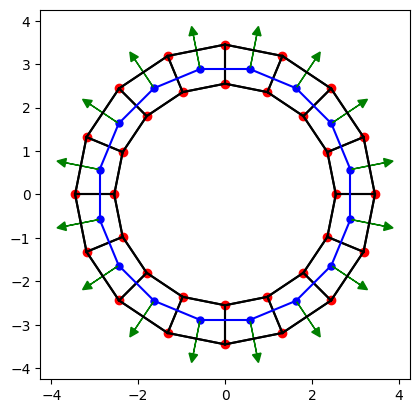

Ring object with 16 cells, 96 half-edges and 32 vertices.
Error: Cell  21  requested for division, but cell count is  18


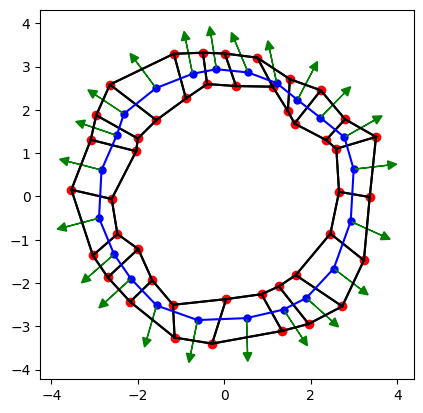

Ring object with 22 cells, 132 half-edges and 44 vertices.
[0.87003924 0.49298247]
[2.77626728 1.36908743]
0.5958846836365268
1.3981379211193068
[0.91689009 0.27494261]
[3.04756248 1.2388506 ]


In [4]:
# import
# only use if the code box above is not used for debugging
from VertexRing import *

#initialize
ringrad = 3.0
# for the test, apply small random deformations relative to the ring radius
disprad = 0.05*ringrad

# create a ring, arguments are cell number and radius
a=Ring()
a.initialize(16,ringrad)

#plot initial ring and display basic properties
a.plot()
print(a)

#do things with the ring to make sure that the data structure is robust
#random displacement
for edge in range(len(a.halfedges)) :
    a.halfedges[edge].v1[0] += 2*disprad*(np.random.random(1)-np.array([0.5]))

#division to check if referenced (/assigned) objects are correct and remain stable
a.divide_cell(6)
a.divide_cell(2)
a.divide_cell(21)


#More mods
#division
a.divide_cell(1)
a.divide_cell(12)
# different ways of modifying vertices
for edge in range(len(a.halfedges)) :
    a.halfedges[edge].v1[0] += disprad*(np.random.random(1)-np.array([0.5]))
    
for vert in range(len(a.vertices)) :
    a.vertices[vert] += disprad*(np.random.random(2)-np.array([0.5,0.5]))

#More mods
#division
a.divide_cell(6)
a.divide_cell(18)

for vert in range(len(a.vertices)) :
    a.vertices[vert] += 2*disprad*(np.random.random(2)-np.array([0.5,0.5]))

#plot for comparison
a.plot()
print(a)

#check some methods
print(a.cells[1].normal())
print(a.cells[1].midpoint())
print(a.cells[5].area())
print(a.halfedges[1].length())
print(a.halfedges[4].vec())
print(a.halfedges[2].midpoint())
